<font size="3">
Celem projektu jest zaimplementowanie i przeprowadzanie analizy porównawczej trzech algorytmów wyznaczania wartości i wektorów własnych macierzy z pokazaniem co najmniej dwóch przykładów zastosowania w analizie danych (np. wyznaczanie minimum formy kwadratowej x^TAx, PCA, SVD, pinv, itp...)

Proponowane aspekty podlegające porównaniu:
<ul>
    <li>ogólność i stabilność metod (analiza dziedziny z możliwością zastosowania),</li>
    <li>zajętość pamięciowa,</li>
    <li>obciążenie procesora,</li>
    <li>wrażliwość na błędy danych,</li>
    <li>ograniczenia co do rozmiaru macierzy.</li>
</ul>

Proponowane algorytmy (proszę samodzielnie wybrać 3):
<ul>
    <li>QR,</li>
    <li>Metoda potęgowa,</li>
    <li>Householder tranformation,</li>
    <li>Lanczos algorithm,</li>
    <li>Jacobie eigenvalue algorithm,</li>
    <li>Locally Optimal Block Preconditioned Conjugate Gradient (LOBPCG)</li>
</ul>
Implementacja algorytmów musi być wykonana w sposób możliwie efektywny i kontrolowany.
Oznacza to, że należy dołożyć starań, aby uruchamiany kod był możliwie zoptymalizowany.

Raport końcowy powinien składać się z czterech części:

<ol>
    <li>wstępu precyzującego jakie algorytmy i w jakim języku zostały zaimplementowane;</li>
    <li>opisu badania, przedstawiającego wybrane przypadki testowe (rodzaje macierzy i jakie cechy tymi macierzami zamierzaliście testować), aspekty porównania oraz (najważniejsze) sposoby i warunki ich pomiaru; w warunkach pomiaru proszę uwzględnić parametry środowiska uruchomieniowego: rozmiar i prędkość pamięci, model procesora, model i typ dysku; niezbędne jest wyszczególnienie wszystkich zastosowanych optymalizacji algorytmów;</li>
    <li>sekcji z wynikami przedstawionymi w odpowiedniej formie wizualnej;</li>
    <li>podsumowania, odnoszącego się do wyników, obiektywnie zestawiających cechy charakterystyczne tych algorytmów; należy skonfrontować uzyskane wyniki ze spodziewanymi; warto odnieść się w dyskusji do aspektu związane z implementacją algorytmów.
    </li>
</ol>
W raporcie końcowym należy między innymi załączyć wykresy prezentujące przebiegi procesu zbiegania się do rozwiązania.

### Pierwszy kamień milowy (10.05 23:59)
- implementacja trzech algorytmów (potęgowa, jacobi, qr),
- optymalizacja (typy, ?),
- testy - wstępne, różne wielkości macierzy, na razie losowe macierze?,
- sprawozdanie - wstępny opis algorytmów, krótki, złożoność obliczeniowa, charakterystka (podział na podstawie obrazka z http://home.agh.edu.pl/~chwiej/mn/problem_wlasny_2016.pdf), wstępny wykres zbieżności, krótki opis testów (tabelka).


### Materiały: 
- performance - https://docs.julialang.org/en/v1/manual/performance-tips/
- Python różnice - https://docs.julialang.org/en/v1/manual/noteworthy-differences/#Noteworthy-differences-from-Python
- http://home.agh.edu.pl/~chwiej/mn/problem_wlasny_2016.pdf
- http://ucidatascienceinitiative.github.io/IntroToJulia/
- https://cheatsheets.quantecon.org/
- http://ucidatascienceinitiative.github.io/IntroToJulia/Html/ArraysAndMatrices
- https://annotate.net/user/Robert-Szmur%C5%82o/awid-05?passid=54561B31-E992-FE1A-5D9E-415434D1D852

In [1]:
A = [45 1 4;
    2 56 1;
    5 9 50]

3×3 Matrix{Int64}:
 45   1   4
  2  56   1
  5   9  50

## Metoda Potęgowa

In [18]:
using Pkg
Pkg.add("PyPlot")


In [5]:
using LinearAlgebra
using BenchmarkTools

In [20]:
using PyPlot

In [9]:
function potegowa(A, l::Integer)
    n = size(A, 1)
    x = ones(n, 1)
#     local x1
    for i in 1:l
#         x1 = x  # why do we need x from step i-1 
        x = A * x
        x = x / norm(x)
    end
#     λ = x'*A*x/(x'*x)  # why is x1 used here
    λ = x'*A*x
    return λ, x
end

potegowa (generic function with 1 method)

In [11]:
@btime potegowa(A, 100)

  26.551 μs (604 allocations: 44.09 KiB)


([58.34154096965294], [0.275294750732188; 0.5667684374955316; 0.7765219497723012])

In [126]:
function potegowav2(A, l::Integer)
    n = size(A, 1)
#     x = ones(Float64, n, 1)
    x = (rand(n) .+ 0.01) .% 1 
#     x1 = Array{Float64}
    for i in 1:l
#         x1 = x  # why do we need x from step i-1 
        x = A * x
        x = x / norm(x)
    end
    λ = x'*A*x/(x'*x)
#     λ = x'*A*x1/(x'*x1)  # why is x1 used here
    return λ, x
end

potegowav2 (generic function with 1 method)

In [7]:
# potegowav2(A, 1000)

In [8]:
# @btime potegowav2(A, 100)

In [8]:
eigen(A)

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
 42.691264195502654
 49.967194893786406
 58.34154091071096
vectors:
3×3 Matrix{Float64}:
 -0.87227     0.556929  -0.275295
  0.0950383  -0.31221   -0.566768
  0.479701    0.769646  -0.776522

## Metoda Jacobiego

In [10]:
display(A)

3×3 Array{Int64,2}:
 1   1   4
 2  56   1
 5   9  12

In [141]:
function eye(n)
    return Matrix{Float64}(I,n,n)
end

function maxst(A)
    s = 1;
    t = 2;
    n = size(A,1);

    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
            s = r;
            t = c;
            end
        end
    end
    return s,t
end


maxst (generic function with 1 method)

In [142]:
function jacobi(A, l::Integer)
    n = size(A,1);
    for i = 1:l
        s,t = maxst(A);
        d = sqrt((A[s,s] - A[t,t])^2 + 4*A[s,t]^2);
        sin2t = 2*A[s,t]/d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2*(1+cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1+ cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        A = R'*A*R;
    end
    return A
end

jacobi (generic function with 1 method)

In [13]:
AJ = jacobi(A, 15)
display(AJ)
diag(AJ)[end:-1:1]

3×3 Array{Float64,2}:
 56.2732    0.0        3.08084e-38
  7.15356  13.2679    -1.92593e-34
  3.79269   0.664874  -0.541099

3-element Array{Float64,1}:
 -0.5410990010433568
 13.267933534846554
 56.273165466196815

In [14]:
eigen(A)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
3-element Array{Float64,1}:
 -0.5410990010433583
 13.26793353484656
 56.273165466196815
vectors:
3×3 Array{Float64,2}:
 -0.935035    0.307084   -0.0323698
  0.0268217  -0.0366269  -0.978724
  0.35354     0.950977   -0.202614

## Metoda QR

In [143]:
# TODO zobaczyć czy for po kolumnach
function mgs(A)
    n = size(A,1);
    R = zeros(n, n);
    Q = zeros(n, n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]'*v;
            v = v - R[i,j]*Q[:,i];
        end
        R[j,j] = norm(v)
        Q[:,j] = v / R[j,j]
    end
    return Q,R
end



mgs (generic function with 1 method)

In [16]:
# AS = [1 5 6;
#     5 23 9;
#     6 9 18]

In [17]:
test, test2 = mgs(A);

In [18]:
display(test)
display(test2)

3×3 Array{Float64,2}:
 0.182574  -0.0873505   0.979304
 0.365148   0.930829    0.0149512
 0.912871  -0.354862   -0.201841

3×3 Array{Float64,2}:
 5.47723  28.8467  12.0499
 0.0      48.8453  -3.67691
 0.0       0.0      1.51007

In [144]:
function QR_eigen(A, l::Integer)
    Q,R = mgs(A)
    for k = 1:l
        Q,R = mgs(A);
        A = R*Q;
    end
    A
end

QR_eigen (generic function with 1 method)

In [20]:
# function QR_eigen_rand(l::Integer)
#     A = rand(5, 5);
#     A = A - tril(A,-1)
#     display(eigen(A))
#     Q,R = mgs(A)
#     for k = 1:l
#         Q,R = mgs(A);
#         A = R*Q;
#     end
#     diag(A)[end:-1:1]
#     A
# end

In [21]:
# QR_eigen_rand(100)

In [22]:
QR_eigen(A, 15)

3×3 Array{Float64,2}:
 56.2732        7.27402      3.58067
  1.45273e-7   13.2679      -0.517151
  2.00205e-28  -5.3929e-20  -0.541099

In [23]:
diag(QR_eigen(A, 15))[end:-1:1]

3-element Array{Float64,1}:
 -0.5410990010433575
 13.267933559418443
 56.273165441624926

In [24]:
diag(QR_eigen(A, 150))[end:-1:1]

3-element Array{Float64,1}:
 -0.5410990010433575
 13.267933534846561
 56.27316546619681

In [25]:
eigen(A)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
3-element Array{Float64,1}:
 -0.5410990010433583
 13.26793353484656
 56.273165466196815
vectors:
3×3 Array{Float64,2}:
 -0.935035    0.307084   -0.0323698
  0.0268217  -0.0366269  -0.978724
  0.35354     0.950977   -0.202614

## Testowanie

### Metoda potęgowa 

1. Macierz z elementami i wektorami własnymi rzeczywistymi

In [109]:
A = randn(5,5)
A = A * diagm(1:5) / A

5×5 Matrix{Float64}:
  4.42312    0.517301  -0.310596   0.838299  -0.481106
  0.586917   3.19204    0.321741   2.43946    1.30625
 -3.24219   -1.94763   -0.445789  -0.441901  -2.60525
  0.131254   0.155579  -0.156325   2.96097   -0.177908
  1.47109    1.44265    2.39441   -0.575054   4.86966

In [119]:
eigvals(A)

5-element Vector{Float64}:
 1.0
 2.0000000000000013
 3.0000000000000018
 4.0
 4.999999999999997

In [117]:
λ, X = eigen(A)
i = sortperm(λ, by=abs, rev=true) # sort the eigenvalues in descending order by magnitude
λ = λ[i]; X = X[:,i]              # and re-order λ and X
λ

5-element Vector{Float64}:
 4.999999999999997
 4.0
 3.0000000000000018
 2.0000000000000013
 1.0

In [111]:
x = (rand(5) .+ 0.01) .% 1# arbitrary initial vector
# for n = 1:100
#     y = x
#     for i = 1:n
#         y = A*y
#         y = y / norm(y)
#     end
# end
x

5-element Vector{Float64}:
 0.1691379867482845
 0.8556793296234653
 0.6472492837262258
 0.905837420159264
 0.2586516872741462

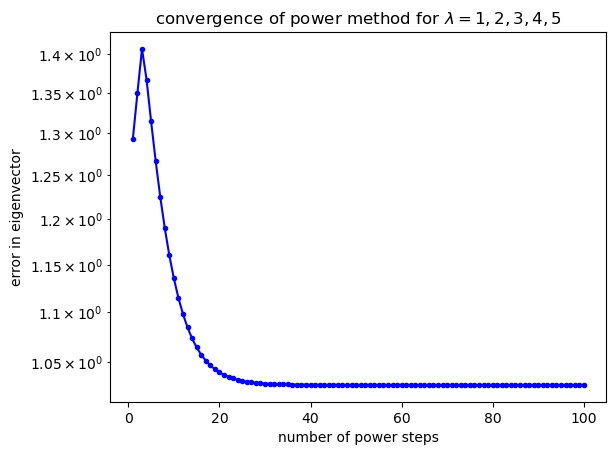

PyObject Text(0.5, 1.0, 'convergence of power method for $\\lambda=1,2,3,4,5$')

In [112]:
d = Float64[]
y = x
for i = 1:100
    y = A*y
    y = y / norm(y)
    push!(d, min(norm(y - X[:,1]), norm(-y - X[:,1]))) # pick the better of the two signs
end
semilogy(1:length(d), d, "b.-")
xlabel("number of power steps")
ylabel("error in eigenvector")
title(L"convergence of power method for $\lambda=1,2,3,4,5$")

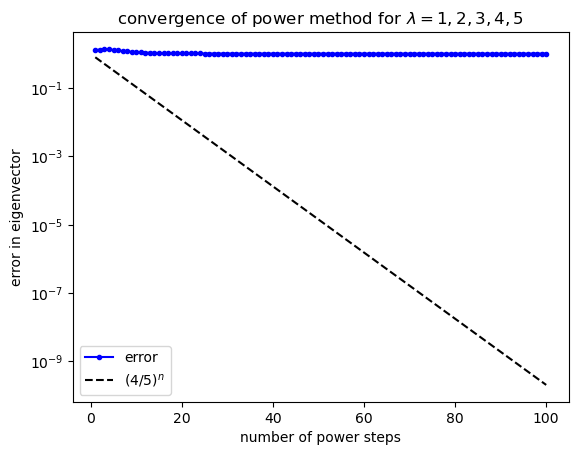

PyObject <matplotlib.legend.Legend object at 0x7f9611aa4c10>

In [113]:
semilogy(1:length(d), d, "b.-")
semilogy(1:length(d), (4/5).^(1:length(d)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvector")
title(L"convergence of power method for $\lambda=1,2,3,4,5$")
legend(["error", L"(4/5)^n"])

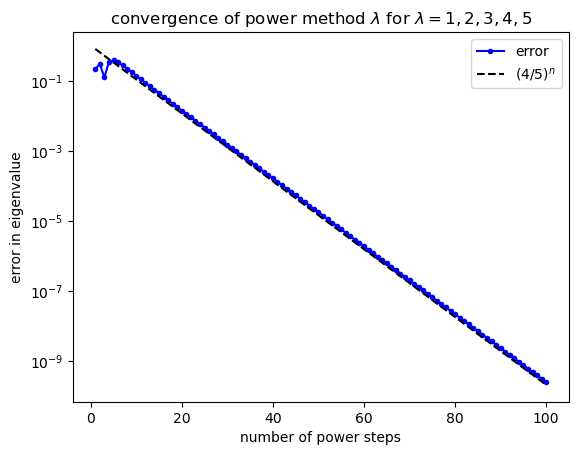

PyObject <matplotlib.legend.Legend object at 0x7f9613f35b20>

In [33]:
Δλ = Float64[]
y = x
for i = 1:100
    y = A*y
    y = y / norm(y)
    λ̃ = (y'A*y) / (y'y)
    push!(Δλ, abs(λ̃ - 5))
end
semilogy(1:length(Δλ), Δλ, "b.-")
semilogy(1:length(Δλ), (4/5).^(1:length(Δλ)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvalue")
title(L"convergence of power method $\lambda$ for $\lambda=1,2,3,4,5$")
legend(["error", L"(4/5)^n"])

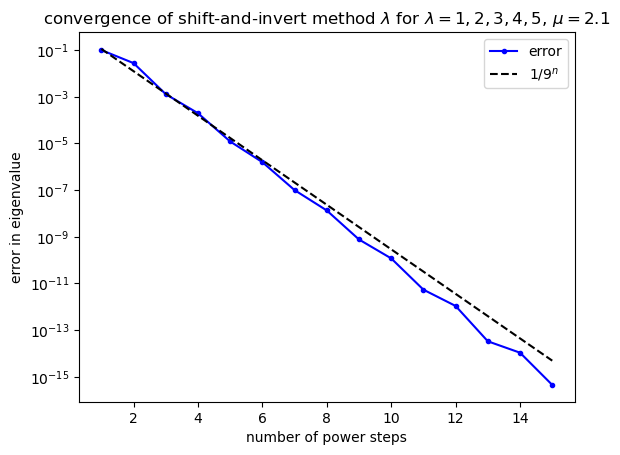

PyObject <matplotlib.legend.Legend object at 0x7f96137b5be0>

In [51]:
Δλ = Float64[]
y = x
for i = 1:15
    y = (A - 2.1I) \ y
    y = y / norm(y)
    λ̃ = (y'A*y) / (y'y)
    push!(Δλ, abs(λ̃ - 2))
end
semilogy(1:length(Δλ), Δλ, "b.-")
semilogy(1:length(Δλ), (1/9).^(1:length(Δλ)), "k--")
xlabel("number of power steps")
ylabel("error in eigenvalue")
title(L"convergence of shift-and-invert method $\lambda$ for $\lambda=1,2,3,4,5$, $\mu = 2.1$")
legend(["error", L"1/9^n"])

In [139]:
n = 20
A = randn(n,n)
A = A * diagm(1:n) / A

BenchmarkTools.Trial: 
  memory estimate:  469.48 KiB
  allocs estimate:  2004
  --------------
  minimum time:     278.907 μs (0.00% GC)
  median time:      298.024 μs (0.00% GC)
  mean time:        326.559 μs (4.76% GC)
  maximum time:     2.248 ms (80.07% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [ ]:
@benchmark potegowav2(A, 1000)

In [137]:
maximum(t)

BenchmarkTools.TrialEstimate: 
  time:             2.076 ms
  gctime:           1.990 ms (95.86%)
  memory:           47.61 KiB
  allocs:           204

In [140]:
@benchmark potegowa(A, 1000)

BenchmarkTools.Trial: 
  memory estimate:  469.34 KiB
  allocs estimate:  2004
  --------------
  minimum time:     576.613 μs (0.00% GC)
  median time:      632.506 μs (0.00% GC)
  mean time:        696.035 μs (2.27% GC)
  maximum time:     3.013 ms (62.24% GC)
  --------------
  samples:          7116
  evals/sample:     1

In [145]:
@benchmark jacobi(A, 1000)

BenchmarkTools.Trial: 
  memory estimate:  9.52 MiB
  allocs estimate:  3000
  --------------
  minimum time:     4.347 ms (0.00% GC)
  median time:      4.855 ms (0.00% GC)
  mean time:        5.436 ms (10.66% GC)
  maximum time:     12.664 ms (28.86% GC)
  --------------
  samples:          915
  evals/sample:     1

In [146]:
@benchmark QR_eigen(A, 1000)

BenchmarkTools.Trial: 
  memory estimate:  192.82 MiB
  allocs estimate:  803802
  --------------
  minimum time:     64.620 ms (10.45% GC)
  median time:      67.686 ms (10.14% GC)
  mean time:        67.992 ms (10.47% GC)
  maximum time:     76.975 ms (8.00% GC)
  --------------
  samples:          74
  evals/sample:     1